In [1]:
pip install pytorch-msssim


Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install numpy

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytorch_msssim import ssim
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import tarfile
import os
import shutil
import requests
import random
import json
import numpy as np
from tqdm import tqdm




In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=3,out_channels = 32, kernel_size=3, padding=1),
            nn.Conv2d(in_channels= 32,out_channels = 64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels= 64, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels= 128, out_channels=128, kernel_size=3, padding=1),
        ])

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = nn.Conv2d(in_channels= 128,out_channels= 32, kernel_size=3, padding=1)

    def forward(self, x):
        for conv in self.conv_layers:
            if conv != self.conv_layers[-1]:
              x = F.relu(conv(x))
              x = self.pool(x)
            else:
              x = F.relu(conv(x))

        x = F.relu(self.bottleneck(x))
        return x

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.deconv_layers = nn.ModuleList([
            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1),
        ])

        self.final_layer = nn.ConvTranspose2d(in_channels=32, out_channels = 3, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.deconv_layers[0](x))
        for deconv in self.deconv_layers[1:]:
            x = F.relu(deconv(x))
        x = torch.sigmoid(self.final_layer(x))
        return x

In [5]:
encoder = Encoder()
decoder = Decoder()


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

Decoder(
  (deconv_layers): ModuleList(
    (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (final_layer): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [10]:


url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"
dataset_path = "256_ObjectCategories.tar"

print(f"Downloading dataset from {url}...")
response = requests.get(url, stream=True)
response.raise_for_status()  # Raise an exception for bad status codes

with open(dataset_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print("Download complete.")

Download complete.


In [11]:

dataset_path = "256_ObjectCategories.tar"
extract_dir = "256_ObjectCategories"

if os.path.exists(dataset_path):
    print(f"Extracting dataset to {extract_dir}...")
    with tarfile.open(dataset_path, "r") as tar:
        tar.extractall(path=extract_dir)
    print("Extraction complete.")
else:
    print(f"Error: The file '{dataset_path}' was not found.")

Extracting dataset to 256_ObjectCategories...


/tmp/ipykernel_2999/2262763269.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


Extraction complete.


In [12]:


# source_dir = "256_ObjectCategories"
# target_dir = "dataset"

# # Create the target directory if it doesn't exist
# os.makedirs(target_dir, exist_ok=True)

# print(f"Consolidating images from '{source_dir}' into '{target_dir}'...")

# # Iterate through all directories and files in the source directory
# for root, dirs, files in os.walk(source_dir, topdown=False): # topdown=False to process subdirectories before their parent
#     for file in files:
#         # Construct the full path to the file
#         file_path = os.path.join(root, file)
#         # Construct the new path for the file in the target directory
#         new_file_path = os.path.join(target_dir, file)

#         # Ensure unique filenames if necessary (optional, depending on dataset)
#         # If filenames might not be unique, you might want to rename them
#         # For this dataset, it seems filenames within a category are unique,
#         # but filenames across categories might not be. Let's rename them
#         # to include the category name to be safe.

#         # Get the category name from the root path
#         category_name = os.path.basename(root)
#         if category_name and category_name != source_dir: # Avoid using the base source dir as category
#              new_file_name = f"{category_name}_{file}"
#              new_file_path = os.path.join(target_dir, new_file_name)


#         try:
#             # Move the file
#             shutil.move(file_path, new_file_path)
#             # print(f"Moved: {file_path} -> {new_file_path}") # Optional: uncomment to see file movements
#         except Exception as e:
#             print(f"Error moving file {file_path}: {e}")

#     # After moving files, remove the subdirectory if it's empty
#     if root != source_dir and not os.listdir(root):
#         try:
#             os.rmdir(root)
#             # print(f"Removed empty directory: {root}") # Optional: uncomment to see removed directories
#         except OSError as e:
#             print(f"Error removing directory {root}: {e}")


# # Optional: remove the original source directory if all files/subdirs were moved
# # Be cautious with this step, only uncomment if you are sure all needed files are moved.
# # if not os.listdir(source_dir):
# #     try:
# #         os.rmdir(source_dir)
# #         print(f"Removed original source directory: {source_dir}")
# #     except OSError as e:
# #          print(f"Error removing source directory {source_dir}: {e}")


# print("Image consolidation complete.")

Consolidating images from '256_ObjectCategories' into 'dataset'...


Image consolidation complete.


In [13]:



# dataset_dir = 'dataset'
# train_dir = 'train'
# val_dir = 'val'

# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# # Get all image files
# all_files = [f for f in os.listdir(dataset_dir) if os.path.isfile(os.path.join(dataset_dir, f))]

# # Shuffle randomly
# random.shuffle(all_files)

# # Split 80% train, 20% val
# split_idx = int(len(all_files) * 0.8)
# train_files = all_files[:split_idx]
# val_files = all_files[split_idx:]

# # Move files
# for f in train_files:
#     shutil.move(os.path.join(dataset_dir, f), os.path.join(train_dir, f))

# for f in val_files:
#     shutil.move(os.path.join(dataset_dir, f), os.path.join(val_dir, f))

# print(f"Total images: {len(all_files)}")
# print(f"Training images: {len(train_files)}")
# print(f"Validation images: {len(val_files)}")


Total images: 30608
Training images: 24486
Validation images: 6122


In [14]:
# from PIL import Image
# import os
# from torchvision import transforms

# transform1 = transforms.Resize((256, 256))  # returns PIL Image

# def process_and_save_images(src_dir):
#     i=0
#     for fname in os.listdir(src_dir):
#       try:
#           i+=1
#           fpath = os.path.join(src_dir, fname)
#           if os.path.isfile(fpath):
#               img = Image.open(fpath).convert('RGB')  # ensure 3 channels
#               img_resized = transform1(img)  # Resize
#               img_resized.save(fpath)        # Save resized image
#               if i % 100 == 0:
#                   print(f"Processed {i} images")
#       except Exception as e:
#           os.remove(fpath)
#           print(f"Error processing {fpath}: {e}")




# # Process train and val
# process_and_save_images(train_dir)
# process_and_save_images(val_dir)


Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images
Processed 4600 imag

In [7]:


transform = transforms.Compose([
    transforms.ToTensor()
])

class ImageFolderNoClass(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [os.path.join(folder_path, f)
                            for f in os.listdir(folder_path)
                            if os.path.isfile(os.path.join(folder_path, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Paths
train_dir = 'train'
val_dir = 'val'

# Create datasets
train_dataset = ImageFolderNoClass(train_dir, transform=transform)
val_dataset = ImageFolderNoClass(val_dir, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

for batch in train_loader:
    print(batch.shape)
    break


torch.Size([32, 3, 256, 256])


In [ ]:

from torch.optim.lr_scheduler import CosineAnnealingLR

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directories
os.makedirs('./checkpoints', exist_ok=True)
loss_file = './checkpoints/losses.json'
model_path = './checkpoints/model.pth'

# Initialize models
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Optimizer & loss
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
l1_criterion = nn.L1Loss()

num_epochs = 500

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)


# Load checkpoint if exists
start_epoch = 0
losses_dict = {
    'train_l1': [], 'train_ssim': [], 'train_total': [],
    'val_l1': [], 'val_ssim': [], 'val_total': []
}

if os.path.exists(model_path):
    print(f"Loading checkpoint from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    losses_dict = checkpoint.get('losses', losses_dict)
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting fresh training.")

# Training loop

for epoch in range(start_epoch, start_epoch + num_epochs):
    encoder.train()
    decoder.train()
    running_l1, running_ssim, running_total = 0.0, 0.0, 0.0

    for images in tqdm(train_loader, desc=f"Epoch {epoch+1}/{start_epoch + num_epochs} [Training]"):
        images = images.to(device)

        optimizer.zero_grad()
        latent = encoder(images)
        outputs = decoder(latent)

        l1_loss_val = l1_criterion(outputs, images)
        ssim_val = ssim(outputs, images, data_range=1.0, size_average = True)
        total_loss = 0.8 * l1_loss_val + 0.2 * (1 - ssim_val)

        total_loss.backward()
        optimizer.step()

        running_l1 += l1_loss_val.item()
        running_ssim += ssim_val.item()
        running_total += total_loss.item()

    # Training loss averages
    train_l1_avg = running_l1 / len(train_loader)
    train_ssim_avg = running_ssim / len(train_loader)
    train_total_avg = running_total / len(train_loader)

    losses_dict['train_l1'].append(train_l1_avg)
    losses_dict['train_ssim'].append(train_ssim_avg)
    losses_dict['train_total'].append(train_total_avg)

    # Validation
    encoder.eval()
    decoder.eval()
    val_l1_total, val_ssim_total, val_total_total = 0.0, 0.0, 0.0

    with torch.no_grad():
        for images in tqdm(val_loader, desc=f"Epoch {epoch+1}/{start_epoch + num_epochs} [Validation]"):
            images = images.to(device)
            latent = encoder(images)
            outputs = decoder(latent)

            l1_loss_val = l1_criterion(outputs, images)
            ssim_val = ssim(outputs, images, data_range=1.0, size_average = True)
            total_loss = 0.8 * l1_loss_val + 0.2 * (1 - ssim_val)

            val_l1_total += l1_loss_val.item()
            val_ssim_total += ssim_val.item()
            val_total_total += total_loss.item()

    val_l1_avg = val_l1_total / len(val_loader)
    val_ssim_avg = val_ssim_total / len(val_loader)
    val_total_avg = val_total_total / len(val_loader)

    losses_dict['val_l1'].append(val_l1_avg)
    losses_dict['val_ssim'].append(val_ssim_avg)
    losses_dict['val_total'].append(val_total_avg)

    print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}] "
          f"Train Loss: {train_total_avg:.4f} (L1: {train_l1_avg:.4f}, SSIM: {train_ssim_avg:.4f}) "
          f"Val Loss: {val_total_avg:.4f} (L1: {val_l1_avg:.4f}, SSIM: {val_ssim_avg:.4f})")

    scheduler.step()

    # Log the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f"Learning Rate after epoch {epoch+1}: {current_lr:.6f}")

    # checkpointing
    torch.save({
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),   
        'epoch': epoch + 1,
        'losses': losses_dict
    }, model_path)



    # Save JSON
    with open(loss_file, 'w') as f:
        json.dump(losses_dict, f, indent=4)


Using device: cuda
Loading checkpoint from ./checkpoints/model.pth...
Checkpoint loaded. Resuming from epoch 278


Epoch 279/778 [Training]:   0%|          | 0/918 [00:00<?, ?it/s]

Epoch 279/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [279/778] Train Loss: 0.0265 (L1: 0.0160, SSIM: 0.9316) Val Loss: 0.0266 (L1: 0.0161, SSIM: 0.9314)
Learning Rate after epoch 279: 0.000410


Epoch 280/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.99it/s]


Epoch [280/778] Train Loss: 0.0264 (L1: 0.0160, SSIM: 0.9317) Val Loss: 0.0265 (L1: 0.0160, SSIM: 0.9313)
Learning Rate after epoch 280: 0.000407


Epoch 281/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.02it/s]


Epoch [281/778] Train Loss: 0.0265 (L1: 0.0160, SSIM: 0.9316) Val Loss: 0.0264 (L1: 0.0159, SSIM: 0.9318)
Learning Rate after epoch 281: 0.000404


Epoch 282/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [282/778] Train Loss: 0.0264 (L1: 0.0160, SSIM: 0.9317) Val Loss: 0.0265 (L1: 0.0160, SSIM: 0.9316)
Learning Rate after epoch 282: 0.000401


Epoch 283/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.87it/s]


Epoch [283/778] Train Loss: 0.0264 (L1: 0.0159, SSIM: 0.9317) Val Loss: 0.0264 (L1: 0.0160, SSIM: 0.9318)
Learning Rate after epoch 283: 0.000398


Epoch 284/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  8.00it/s]


Epoch [284/778] Train Loss: 0.0264 (L1: 0.0159, SSIM: 0.9318) Val Loss: 0.0266 (L1: 0.0160, SSIM: 0.9312)
Learning Rate after epoch 284: 0.000395


Epoch 285/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [285/778] Train Loss: 0.0264 (L1: 0.0159, SSIM: 0.9318) Val Loss: 0.0267 (L1: 0.0162, SSIM: 0.9313)
Learning Rate after epoch 285: 0.000392


Epoch 286/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.98it/s]


Epoch [286/778] Train Loss: 0.0264 (L1: 0.0159, SSIM: 0.9318) Val Loss: 0.0266 (L1: 0.0162, SSIM: 0.9316)
Learning Rate after epoch 286: 0.000388


Epoch 287/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.91it/s]


Epoch [287/778] Train Loss: 0.0264 (L1: 0.0159, SSIM: 0.9318) Val Loss: 0.0264 (L1: 0.0159, SSIM: 0.9317)
Learning Rate after epoch 287: 0.000385


Epoch 288/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.04it/s]


Epoch [288/778] Train Loss: 0.0263 (L1: 0.0159, SSIM: 0.9319) Val Loss: 0.0264 (L1: 0.0160, SSIM: 0.9321)
Learning Rate after epoch 288: 0.000382


Epoch 289/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.93it/s]


Epoch [289/778] Train Loss: 0.0263 (L1: 0.0159, SSIM: 0.9319) Val Loss: 0.0266 (L1: 0.0162, SSIM: 0.9316)
Learning Rate after epoch 289: 0.000379


Epoch 290/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.88it/s]


Epoch [290/778] Train Loss: 0.0263 (L1: 0.0159, SSIM: 0.9319) Val Loss: 0.0264 (L1: 0.0160, SSIM: 0.9320)
Learning Rate after epoch 290: 0.000376


Epoch 291/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.92it/s]


Epoch [291/778] Train Loss: 0.0263 (L1: 0.0159, SSIM: 0.9320) Val Loss: 0.0262 (L1: 0.0157, SSIM: 0.9321)
Learning Rate after epoch 291: 0.000373


Epoch 292/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [292/778] Train Loss: 0.0263 (L1: 0.0158, SSIM: 0.9320) Val Loss: 0.0264 (L1: 0.0158, SSIM: 0.9314)
Learning Rate after epoch 292: 0.000370


Epoch 293/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [293/778] Train Loss: 0.0263 (L1: 0.0159, SSIM: 0.9320) Val Loss: 0.0262 (L1: 0.0157, SSIM: 0.9319)
Learning Rate after epoch 293: 0.000367


Epoch 294/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [294/778] Train Loss: 0.0262 (L1: 0.0158, SSIM: 0.9321) Val Loss: 0.0264 (L1: 0.0159, SSIM: 0.9316)
Learning Rate after epoch 294: 0.000364


Epoch 295/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [295/778] Train Loss: 0.0263 (L1: 0.0159, SSIM: 0.9320) Val Loss: 0.0262 (L1: 0.0157, SSIM: 0.9319)
Learning Rate after epoch 295: 0.000361


Epoch 296/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.97it/s]


Epoch [296/778] Train Loss: 0.0263 (L1: 0.0158, SSIM: 0.9321) Val Loss: 0.0263 (L1: 0.0158, SSIM: 0.9317)
Learning Rate after epoch 296: 0.000358


Epoch 297/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.00it/s]


Epoch [297/778] Train Loss: 0.0262 (L1: 0.0158, SSIM: 0.9321) Val Loss: 0.0264 (L1: 0.0161, SSIM: 0.9321)
Learning Rate after epoch 297: 0.000355


Epoch 298/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.94it/s]


Epoch [298/778] Train Loss: 0.0262 (L1: 0.0158, SSIM: 0.9321) Val Loss: 0.0266 (L1: 0.0162, SSIM: 0.9317)
Learning Rate after epoch 298: 0.000352


Epoch 299/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.00it/s]


Epoch [299/778] Train Loss: 0.0262 (L1: 0.0158, SSIM: 0.9322) Val Loss: 0.0270 (L1: 0.0165, SSIM: 0.9311)
Learning Rate after epoch 299: 0.000349


Epoch 300/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.00it/s]


Epoch [300/778] Train Loss: 0.0262 (L1: 0.0158, SSIM: 0.9322) Val Loss: 0.0262 (L1: 0.0158, SSIM: 0.9321)
Learning Rate after epoch 300: 0.000346


Epoch 301/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.93it/s]


Epoch [301/778] Train Loss: 0.0262 (L1: 0.0158, SSIM: 0.9322) Val Loss: 0.0262 (L1: 0.0158, SSIM: 0.9320)
Learning Rate after epoch 301: 0.000343


Epoch 302/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.00it/s]


Epoch [302/778] Train Loss: 0.0262 (L1: 0.0158, SSIM: 0.9322) Val Loss: 0.0263 (L1: 0.0159, SSIM: 0.9321)
Learning Rate after epoch 302: 0.000340


Epoch 303/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [303/778] Train Loss: 0.0261 (L1: 0.0157, SSIM: 0.9323) Val Loss: 0.0263 (L1: 0.0159, SSIM: 0.9320)
Learning Rate after epoch 303: 0.000337


Epoch 304/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.94it/s]


Epoch [304/778] Train Loss: 0.0262 (L1: 0.0158, SSIM: 0.9323) Val Loss: 0.0266 (L1: 0.0163, SSIM: 0.9321)
Learning Rate after epoch 304: 0.000334


Epoch 305/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.02it/s]


Epoch [305/778] Train Loss: 0.0261 (L1: 0.0158, SSIM: 0.9323) Val Loss: 0.0263 (L1: 0.0158, SSIM: 0.9318)
Learning Rate after epoch 305: 0.000331


Epoch 306/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.02it/s]


Epoch [306/778] Train Loss: 0.0261 (L1: 0.0158, SSIM: 0.9323) Val Loss: 0.0263 (L1: 0.0158, SSIM: 0.9318)
Learning Rate after epoch 306: 0.000328


Epoch 307/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.98it/s]


Epoch [307/778] Train Loss: 0.0261 (L1: 0.0158, SSIM: 0.9323) Val Loss: 0.0265 (L1: 0.0159, SSIM: 0.9313)
Learning Rate after epoch 307: 0.000325


Epoch 308/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.91it/s]


Epoch [308/778] Train Loss: 0.0261 (L1: 0.0158, SSIM: 0.9323) Val Loss: 0.0261 (L1: 0.0157, SSIM: 0.9322)
Learning Rate after epoch 308: 0.000322


Epoch 309/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  8.00it/s]


Epoch [309/778] Train Loss: 0.0261 (L1: 0.0157, SSIM: 0.9324) Val Loss: 0.0269 (L1: 0.0165, SSIM: 0.9314)
Learning Rate after epoch 309: 0.000320


Epoch 310/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [310/778] Train Loss: 0.0261 (L1: 0.0157, SSIM: 0.9324) Val Loss: 0.0267 (L1: 0.0163, SSIM: 0.9319)
Learning Rate after epoch 310: 0.000317


Epoch 311/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.02it/s]


Epoch [311/778] Train Loss: 0.0261 (L1: 0.0157, SSIM: 0.9324) Val Loss: 0.0266 (L1: 0.0161, SSIM: 0.9316)
Learning Rate after epoch 311: 0.000314


Epoch 312/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.01it/s]


Epoch [312/778] Train Loss: 0.0261 (L1: 0.0157, SSIM: 0.9325) Val Loss: 0.0261 (L1: 0.0157, SSIM: 0.9323)
Learning Rate after epoch 312: 0.000311


Epoch 313/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.92it/s]


Epoch [313/778] Train Loss: 0.0261 (L1: 0.0157, SSIM: 0.9325) Val Loss: 0.0261 (L1: 0.0157, SSIM: 0.9325)
Learning Rate after epoch 313: 0.000308


Epoch 314/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.02it/s]


Epoch [314/778] Train Loss: 0.0262 (L1: 0.0158, SSIM: 0.9323) Val Loss: 0.0262 (L1: 0.0159, SSIM: 0.9325)
Learning Rate after epoch 314: 0.000305


Epoch 315/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.94it/s]


Epoch [315/778] Train Loss: 0.0260 (L1: 0.0157, SSIM: 0.9326) Val Loss: 0.0263 (L1: 0.0159, SSIM: 0.9321)
Learning Rate after epoch 315: 0.000302


Epoch 316/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.95it/s]


Epoch [316/778] Train Loss: 0.0261 (L1: 0.0158, SSIM: 0.9324) Val Loss: 0.0262 (L1: 0.0158, SSIM: 0.9322)
Learning Rate after epoch 316: 0.000299


Epoch 317/778 [Validation]: 100%|██████████| 344/344 [00:42<00:00,  8.02it/s]


Epoch [317/778] Train Loss: 0.0261 (L1: 0.0157, SSIM: 0.9325) Val Loss: 0.0262 (L1: 0.0157, SSIM: 0.9318)
Learning Rate after epoch 317: 0.000296


Epoch 318/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.90it/s]


Epoch [318/778] Train Loss: 0.0260 (L1: 0.0156, SSIM: 0.9326) Val Loss: 0.0260 (L1: 0.0157, SSIM: 0.9324)
Learning Rate after epoch 318: 0.000294


Epoch 319/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.94it/s]


Epoch [319/778] Train Loss: 0.0260 (L1: 0.0157, SSIM: 0.9326) Val Loss: 0.0262 (L1: 0.0158, SSIM: 0.9320)
Learning Rate after epoch 319: 0.000291


Epoch 320/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.97it/s]


Epoch [320/778] Train Loss: 0.0260 (L1: 0.0156, SSIM: 0.9326) Val Loss: 0.0261 (L1: 0.0158, SSIM: 0.9327)
Learning Rate after epoch 320: 0.000288


Epoch 321/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.94it/s]


Epoch [321/778] Train Loss: 0.0260 (L1: 0.0156, SSIM: 0.9327) Val Loss: 0.0261 (L1: 0.0157, SSIM: 0.9323)
Learning Rate after epoch 321: 0.000285


Epoch 322/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  8.00it/s]


Epoch [322/778] Train Loss: 0.0260 (L1: 0.0157, SSIM: 0.9326) Val Loss: 0.0261 (L1: 0.0157, SSIM: 0.9325)
Learning Rate after epoch 322: 0.000282


Epoch 323/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  8.00it/s]


Epoch [323/778] Train Loss: 0.0260 (L1: 0.0157, SSIM: 0.9326) Val Loss: 0.0260 (L1: 0.0156, SSIM: 0.9323)
Learning Rate after epoch 323: 0.000279


Epoch 324/778 [Validation]: 100%|██████████| 344/344 [00:43<00:00,  7.91it/s]


Epoch [324/778] Train Loss: 0.0259 (L1: 0.0156, SSIM: 0.9328) Val Loss: 0.0259 (L1: 0.0155, SSIM: 0.9325)
Learning Rate after epoch 324: 0.000277


Epoch 325/778 [Validation]:  50%|████▉     | 171/344 [00:21<00:22,  7.76it/s]

In [54]:
print(val_dataset[50][0].shape)

torch.Size([256, 256])


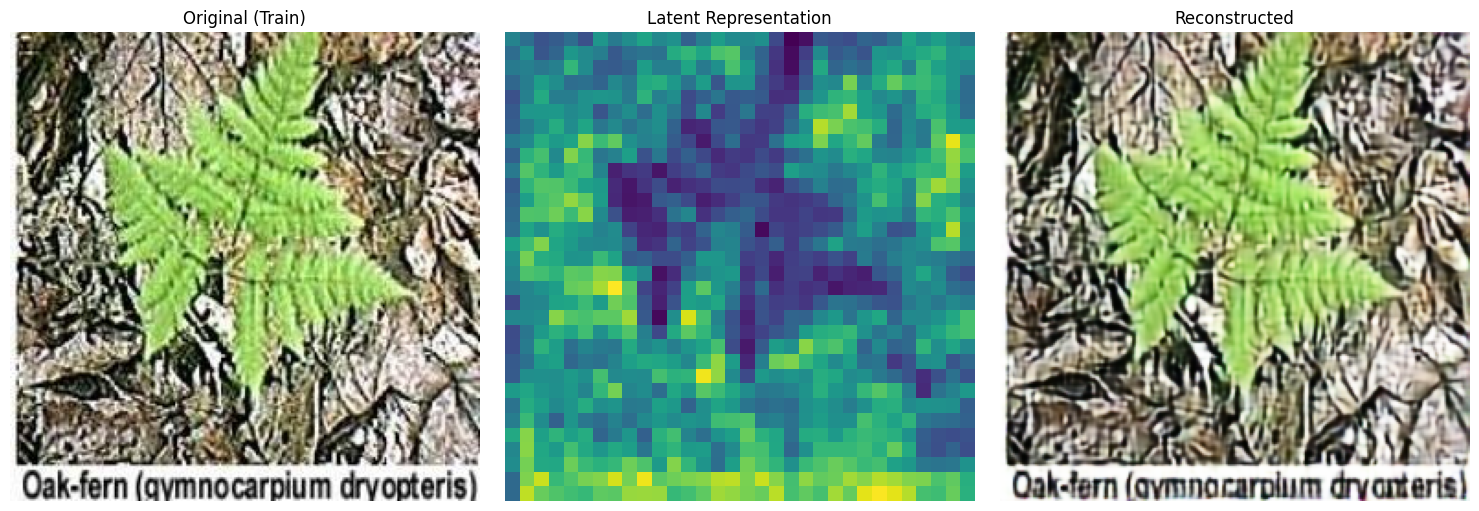

 Dataset: Train
 Random index: 7164
Original shape: (1, 3, 256, 256)
 Latent shape: (1, 32, 32, 32)
Original size: 768.00 KB
Latent size: 128.00 KB
Compression ratio: 6.00x smaller


In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Ensure models are ready
encoder.to(device)
decoder.to(device)
encoder.eval()
decoder.eval()

# Randomly choose dataset
if random.random() < 0.5:
    dataset_name = "Train"
    dataset = train_dataset
else:
    dataset_name = "Validation"
    dataset = val_dataset

# Pick random image
sample_index = random.randint(0, len(dataset) - 1)
sample = dataset[sample_index]
sample_image_tensor = sample[0] if isinstance(sample, tuple) else sample

# Add batch dimension and send to device
sample_image_tensor = sample_image_tensor.unsqueeze(0).to(device)

# Forward pass
with torch.no_grad():
    latent_representation = encoder(sample_image_tensor)
    reconstructed_image_tensor = decoder(latent_representation)

# Move tensors to CPU for visualization
sample_image_np = sample_image_tensor.squeeze(0).cpu().numpy()
reconstructed_image_np = reconstructed_image_tensor.squeeze(0).cpu().numpy()
latent_np = latent_representation.squeeze(0).cpu().numpy()

# Transpose for visualization
sample_image_np = np.clip(np.transpose(sample_image_np, (1, 2, 0)), 0, 1)
reconstructed_image_np = np.clip(np.transpose(reconstructed_image_np, (1, 2, 0)), 0, 1)

# For latent visualization — flatten channel dimension into one grayscale image
latent_visual = latent_np
if latent_visual.ndim == 3:
    # Normalize each channel and take mean projection
    latent_visual = np.mean(latent_visual, axis=0)
latent_visual = (latent_visual - latent_visual.min()) / (latent_visual.max() - latent_visual.min() + 1e-8)

# Compute sizes
orig_size = sample_image_tensor.numel() * 4  # float32 = 4 bytes
latent_size = latent_representation.numel() * 4
compression_ratio = orig_size / latent_size

# Plot all three
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(sample_image_np)
plt.title(f"Original ({dataset_name})")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(latent_visual, cmap="viridis")
plt.title("Latent Representation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image_np)
plt.title("Reconstructed")
plt.axis("off")

plt.tight_layout()
plt.show()

# Print details
print(f" Dataset: {dataset_name}")
print(f" Random index: {sample_index}")
print(f"Original shape: {tuple(sample_image_tensor.shape)}")
print(f" Latent shape: {tuple(latent_representation.shape)}")
print(f"Original size: {orig_size/1024:.2f} KB")
print(f"Latent size: {latent_size/1024:.2f} KB")
print(f"Compression ratio: {compression_ratio:.2f}x smaller")


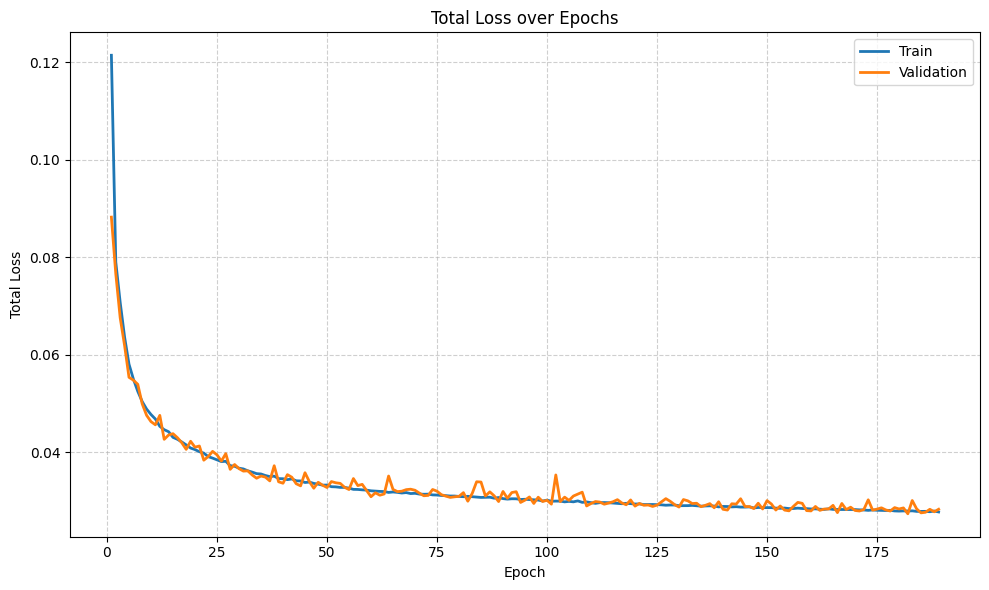

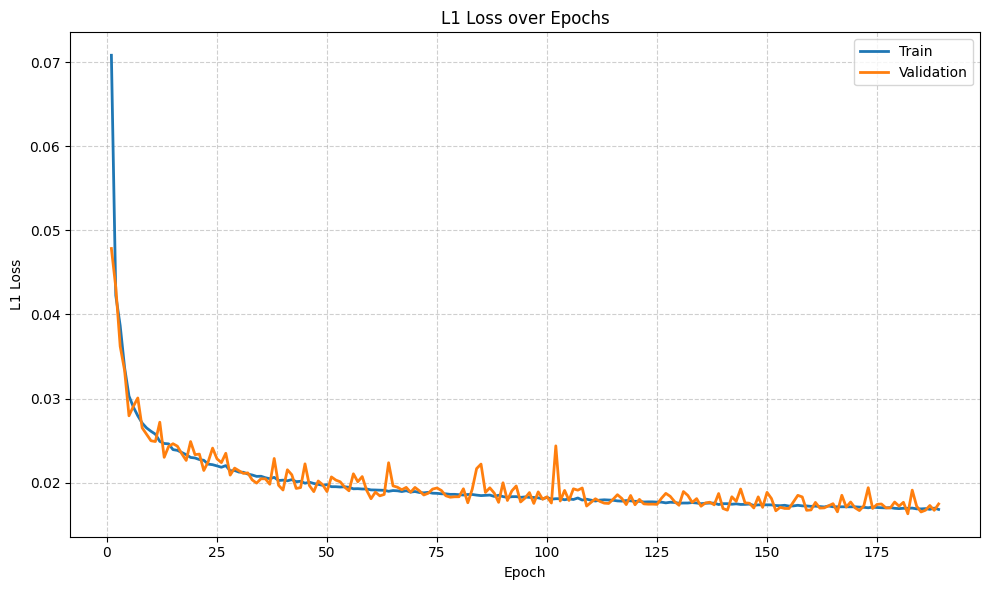

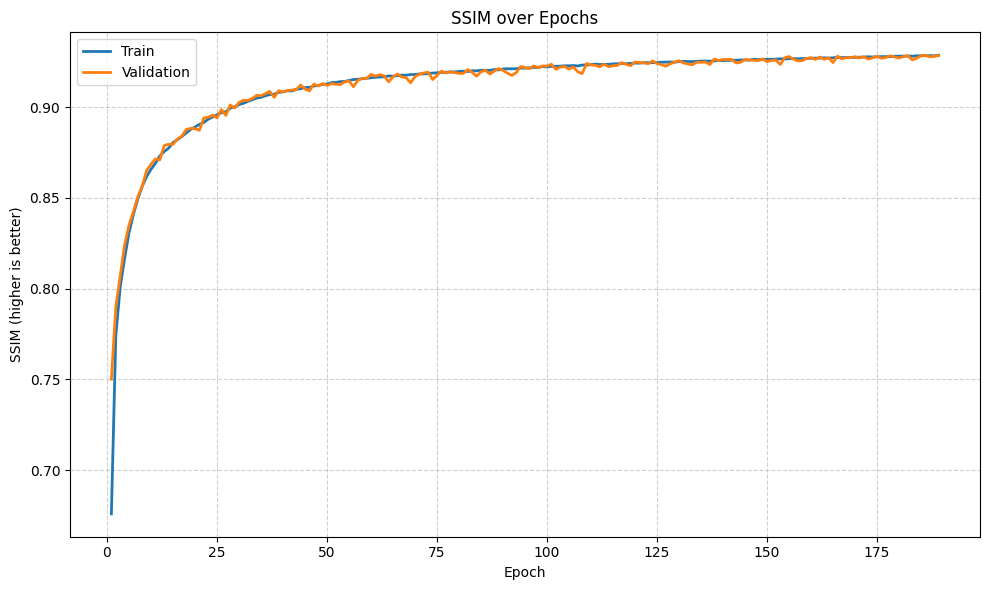

Final Epoch: 189
Train Total Loss: 0.0277 | Val Total Loss: 0.0283
Train L1: 0.0168 | Val L1: 0.0174
Train SSIM: 0.9285 | Val SSIM: 0.9283


In [19]:
import json
import matplotlib.pyplot as plt
import os

# Path to your saved JSON file
loss_file = './checkpoints/losses.json'

if not os.path.exists(loss_file):
    raise FileNotFoundError(f"Loss file not found at {loss_file}")

# Load loss data
with open(loss_file, 'r') as f:
    losses = json.load(f)

# Extract values
train_l1 = losses.get('train_l1', [])
val_l1 = losses.get('val_l1', [])
train_ssim = losses.get('train_ssim', [])
val_ssim = losses.get('val_ssim', [])
train_total = losses.get('train_total', [])
val_total = losses.get('val_total', [])

epochs = range(1, len(train_l1) + 1)

# --------------------------
# Helper function for plotting
# --------------------------
def plot_loss(train_vals, val_vals, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_vals, label='Train', linewidth=2)
    plt.plot(epochs, val_vals, label='Validation', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --------------------------
# Plot each loss
# --------------------------
plot_loss(train_total, val_total, 'Total Loss over Epochs', 'Total Loss')
plot_loss(train_l1, val_l1, 'L1 Loss over Epochs', 'L1 Loss')
plot_loss(train_ssim, val_ssim, 'SSIM over Epochs', 'SSIM (higher is better)')

# --------------------------
# Optional summary
# --------------------------
print(f"Final Epoch: {len(train_l1)}")
print(f"Train Total Loss: {train_total[-1]:.4f} | Val Total Loss: {val_total[-1]:.4f}")
print(f"Train L1: {train_l1[-1]:.4f} | Val L1: {val_l1[-1]:.4f}")
print(f"Train SSIM: {train_ssim[-1]:.4f} | Val SSIM: {val_ssim[-1]:.4f}")
